# Build Sentinel-2 Data Cubes

This notebook demonstrates how to construct 3D data cubes from multiple Sentinel-2 tiles using [**xcube-eopf**](https://github.com/EOPF-Sample-Service/xcube-eopf). The following steps are performed by **xcube-eopf** to generate the data cubes:

- **Query tiles**: Identify relevant Sentinel-2 tiles based on a spatiotemporal search using the [EOPF Zarr Sample Service STAC API](https://stac.core.eopf.eodc.eu).
- **Group by tile and date**: Organize STAC items by MGRS tile ID and solar day.
- **Spatial mosaicking**: Merge adjacent tiles acquired on the same day into seamless scenes.
- **Time stacking**: Combine daily mosaics along the time dimension to form 3D data cubes for each data variable (e.g., spectral bands).


In [1]:
from xcube.core.store import new_data_store
from xcube_eopf.utils import reproject_bbox
import xarray as xr

In [2]:
xr.set_options(display_expand_attrs=False)

To initialize an `eopf-zarr` [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework), execute the cell below:

In [3]:
store = new_data_store("eopf-zarr")

The data IDs point to [STAC collections](https://stac.browser.user.eopf.eodc.eu). So far only `'sentinel-2-l1c'` and `'sentinel-2-l2a'` is supported.

In [4]:
data_ids = store.list_data_ids()
data_ids

['sentinel-2-l1c', 'sentinel-2-l2a']

Below, the parameters for the `open_data` method can be viewed for each supported data product. 

In [5]:
open_params = store.get_open_data_params_schema()
open_params

This function also shows opening parameters for a specific `data_id`, as shown below. 

In [6]:
open_params = store.get_open_data_params_schema(data_id="sentinel-2-l2a")
open_params

We now want to generate a data cube from the Sentinel-2 L2A product. We therefore assign `data_id` to `"sentinel-2-l2a"`. We set the bounding box to cover the greater Hamburg area and the time range to the first half of Mai 2025. We first want to get the datacube in the native UTM projection. 

In [7]:
bbox = [9.1, 53.1, 10.7, 54]
crs_target = "EPSG:32632"
bbox_utm = reproject_bbox(bbox, "EPSG:4326", crs_target)

In [8]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox_utm,
    time_range=["2025-05-01", "2025-05-15"],
    spatial_res=10,
    crs=crs_target,
    variables=["b02", "b03", "b04", "scl"],
)
ds

CPU times: user 5.96 s, sys: 318 ms, total: 6.28 s
Wall time: 1min 38s


<xarray.Dataset> Size: 24GB
Dimensions:      (time: 9, y: 10147, x: 10727)
Coordinates:
  * time         (time) datetime64[ns] 72B 2025-05-01T10:40:41.025000 ... 202...
    spatial_ref  int64 8B ...
  * x            (x) float64 86kB 5.066e+05 5.066e+05 ... 6.138e+05 6.138e+05
  * y            (y) float64 81kB 5.985e+06 5.985e+06 ... 5.883e+06 5.883e+06
Data variables:
    b02          (time, y, x) float64 8GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b03          (time, y, x) float64 8GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b04          (time, y, x) float64 8GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    scl          (time, y, x) uint8 980MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
Attributes: (4)

CPU times: user 14 s, sys: 5.6 s, total: 19.6 s
Wall time: 25.7 s


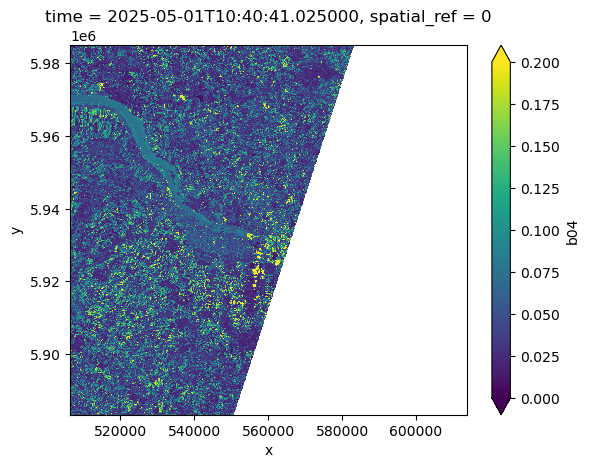

In [9]:
%%time
ds.b04.isel(time=0)[::10, ::10].plot(vmin=0, vmax=0.2)

Now wecan request the same data cube but in geographic projection (`"EPSG:4326"`). xcube-eopf can reproject the datacube to any projection requested by the user. 

In [10]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox,
    time_range=["2025-05-01", "2025-05-15"],
    spatial_res=10 / 111320, # meter in degree,
    crs="EPSG:4326",
    variables=["b02", "b03", "b04", "scl"],
)
ds

CPU times: user 4min 12s, sys: 420 ms, total: 4min 12s
Wall time: 5min 44s


<xarray.Dataset> Size: 40GB
Dimensions:      (time: 9, lon: 17813, lat: 10020)
Coordinates:
  * time         (time) datetime64[ns] 72B 2025-05-01T10:40:41.025000 ... 202...
    spatial_ref  int64 8B 0
  * lon          (lon) float64 143kB 9.1 9.1 9.1 9.1 9.1 ... 10.7 10.7 10.7 10.7
  * lat          (lat) float64 80kB 54.0 54.0 54.0 54.0 ... 53.1 53.1 53.1 53.1
Data variables:
    b02          (time, lat, lon) float64 13GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b03          (time, lat, lon) float64 13GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b04          (time, lat, lon) float64 13GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    scl          (time, lat, lon) uint8 2GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
Attributes: (4)

CPU times: user 1min 5s, sys: 7.84 s, total: 1min 13s
Wall time: 29.8 s


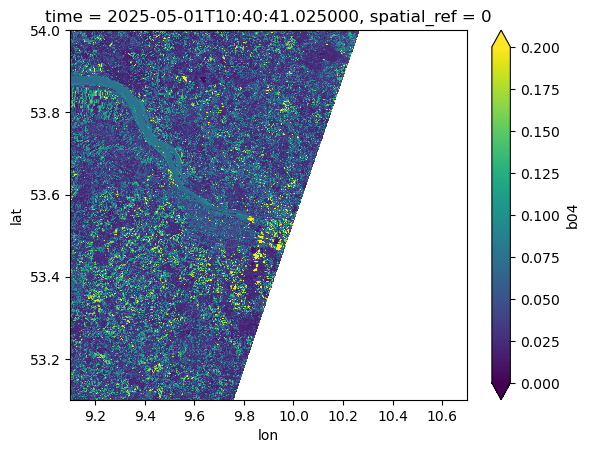

In [11]:
%%time
ds.b04.isel(time=0)[::10, ::10].plot(vmin=0, vmax=0.2)

We now want to generate a similar data cube from the Sentinel-2 L1C product. We therefore assign `data_id` to `"sentinel-2-l1c"`.

In [12]:
# "sentinel-2-l1c" produces 504 error; see issue https://github.com/EOPF-Sample-Service/PMP/issues/207
%%time
ds = store.open_data(
    data_id="sentinel-2-l1c",
    bbox=bbox_utm,
    time_range=["2025-05-01", "2025-05-15"],
    spatial_res=10,
    crs=crs_target,
    variables=["b02", "b03", "b04", "scl"],
)
ds

ClientResponseError: 504, message='Gateway Time-out', url='https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:202505-s02msil1c/01/products/cpm_v256/S2C_MSIL1C_20250501T104041_N0511_R008_T32UME_20250501T141904.zarr/conditions/geometry/band/0'

In [13]:
%%time
ds.b04.isel(time=0)[::10, ::10].plot(vmin=0, vmax=0.2)

ClientResponseError: 504, message='Gateway Time-out', url='https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:202505-s02msil2a/01/products/cpm_v256/S2C_MSIL2A_20250501T104041_N0511_R008_T32UND_20250501T161558.zarr/measurements/reflectance/r10m/b03/0.4'